# Generative Adversarial Network (GAN)

Generative Adversarial Networks (GANs)는 가짜 데이터를 생성하는 generator와 진짜와 가짜를 구분하는 discriminator를 경쟁시키는 방식으로 학습시키는 생성모델입니다.

이번 실습에서는 숫자 이미지 데이터셋 MNIST에 간단한 GAN을 학습시켜 보겠습니다.

<img src="images/gan_mnist.png" alt="Drawing" style="width: 800px;"/>



## Import libraries

필요한 라이브러리를 임포트해줍니다. 이 노트북은 tensorflow 1.14 기준으로 작성되었기에 eager execution을 명시적으로 켜주겠습니다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
tf.enable_eager_execution()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.keras import layers

print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.executing_eagerly())

1.14.0
True
True


## Data

MNIST 데이터를 가져옵시다. 여기서는 label이 필요하지 않으며, train set만 사용하겠습니다. 또한, 현재 0에서 255인 픽셀값이 -1에서 1의 범위를 가지도록 정규화를 해주겠습니다.

In [3]:
BATCH_SIZE = 256
(images, _), (_, _) = tf.keras.datasets.mnist.load_data() # (60000, 28, 28)
images = images.reshape(images.shape[0], 28, 28, 1).astype('float32') # (60000, 28, 28, 1)
images = (images-127.5)/127.5
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(images.shape[0]).batch(BATCH_SIZE)

로드한 MNIST 이미지 중 몇장을 시각화해봅시다. 같은 숫자라도 다양한 스타일로 적혀있는 것을 확인할 수 있습니다.

In [4]:
def visualize_batch(images):
    M = 4
    fig = plt.figure(figsize=(M,M))
    for i in range(M*M):
        plt.subplot(M, M, i+1)
        plt.imshow(images[i, :, :, 0]*127.5+127.5, cmap='gray')
        plt.axis('off')
    plt.show()

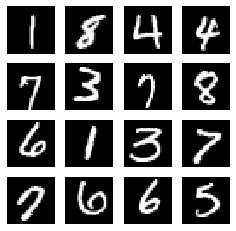

In [5]:
for real_image in dataset:
    break
visualize_batch(real_image.numpy())

## Model

### Generator

$ G: \mathbb{R}^{100} \rightarrow \mathbb{R}^{28 \times 28} $

Generator는 노이즈로부터 가짜 데이터를 생성하는 역할을 합니다. 우리 모델에서는 노이즈의 차원을 100으로 하겠습니다.

(B, 100)크기의 노이즈를 input으로 하고, (B, 28, 28, 1) 크기의 흑백 이미지를 output으로 하는 신경망을 Keras API를 이용하여 구현하겠습니다.

In [8]:
NOISE_DIM = 100

def make_generator_model(verbose=False):
    
    model = tf.keras.Sequential()
    
    # FC & reshape
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    if verbose:
        print(model.output_shape)
    
    # ConvTrans1
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    if verbose:
        print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # ConvTrans2
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    if verbose:
        print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # ConvTrans3
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    if verbose:
        print(model.output_shape)
    
    return model

In [9]:
def test1():
    gen_net = make_generator_model(verbose=True)
test1()

(None, 7, 7, 256)
(None, 7, 7, 128)
(None, 14, 14, 64)
(None, 28, 28, 1)


### Discriminator

Discriminator는 주어진 input이 진짜인지 가짜인지 판단하는 역할을 합니다. 진짜는 1, 가짜면 0을 target으로 학습될 것입니다.

$ D: \mathbb{R}^{28 \times 28} \rightarrow [0, 1]$

우리의 모델에서는, 맨 끝단의 sigmoid layer를 생략하고 범위제한이 없는 logit을 output으로 하겠습니다.

(B, 28, 28, 1) 크기의 흑백 이미지를 input으로 하고 (B, 1) 크기의 판단 결과를 output으로 하는 신경망을 구현하겠습니다.

In [10]:
def make_discriminator_model(verbose=False):
    
    model = tf.keras.Sequential()
    
    # Conv1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    if verbose: print(model.output_shape)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Conv2
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    if verbose: print(model.output_shape)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # reshape & FC
    model.add(layers.Flatten())
    if verbose: print(model.output_shape)
    
    model.add(layers.Dense(1))
    if verbose: print(model.output_shape)
    
    return model

In [11]:
def test2():
    disc_net = make_discriminator_model(verbose=True)
test2()

(None, 14, 14, 64)
(None, 7, 7, 128)
(None, 6272)
(None, 1)


트레이닝 되지 않은 generator와 discriminator로 이미지를 생성하고, 평가해봅시다.

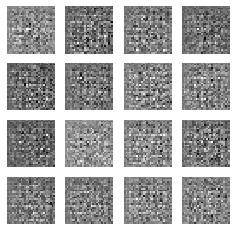

(256, 1)


In [12]:
def test3():
    gen_net = make_generator_model()
    disc_net = make_discriminator_model()
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    fake_images = gen_net(noise, training=False)
    visualize_batch(fake_images.numpy())
    fake_d_out = disc_net(fake_images)
    print(fake_d_out.shape)
test3()

## Training

한 iteration에 대한 트레이닝 루틴을 구현해봅시다. Discriminator는 real image에 대해서는 1으로 평가하도록, fake image에 대해서는 0으로 평가하도록 학습해야합니다. Generator는 자신이 생성한 fake image가 discriminator에 의해 1에 가까운 평가를 받도록 학습해야합니다. 이 의도에 맞게 loss를 설계하면 다음과 같습니다.

$ \textrm{discriminator loss} = \mathbb{E}_{x \sim \textrm{data}}[- \log (D(x))] + \mathbb{E}_{z \sim \textrm{noise}}[- \log (1 - D(G(z)))]$

$ \textrm{generator loss} = \mathbb{E}_{z \sim \textrm{noise}}[- \log (D(G(z)))]$

위 내용을 바탕으로 GAN의 loss term들을 구현해봅시다.

(주의: disc_net의 output은 0-1사이 값이 아니라 sigmoid를 통과하지 않아 범위가 정해지지 않은 logit입니다.) 

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_iter(real_image, gen_net, disc_net, gen_opt, disc_opt, skip_gen=False, skip_disc=False):
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        # --------------------------------------------------------------
        # TODO: implement GAN loss terms: gen_loss, real_disc_loss, fake_disc_loss
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        fake_image = gen_net(noise, training=True)
        real_d_out = disc_net(real_image, training=True)
        fake_d_out = disc_net(fake_image, training=True)
        gen_loss = cross_entropy(tf.ones_like(fake_d_out), fake_d_out)
        real_disc_loss = cross_entropy(tf.ones_like(real_d_out), real_d_out)
        fake_disc_loss = cross_entropy(tf.zeros_like(fake_d_out), fake_d_out)
        # --------------------------------------------------------------
        disc_loss = real_disc_loss + fake_disc_loss
    if not skip_gen:
        gen_grad = gen_tape.gradient(gen_loss, gen_net.trainable_variables)
        gen_opt.apply_gradients(zip(gen_grad, gen_net.trainable_variables))
    if not skip_disc:
        disc_grad = disc_tape.gradient(disc_loss, disc_net.trainable_variables)
        disc_opt.apply_gradients(zip(disc_grad, disc_net.trainable_variables))
    return gen_loss, real_disc_loss, fake_disc_loss

한 epoch에 대한 트레이닝 루틴입니다. SKIP_GEN_ITERS, SKIP_DISC_ITERS를 통해 학습페이스를 조절할 수 있습니다.

In [14]:
SKIP_GEN_ITERS = 1
SKIP_DISC_ITERS = 1
def train_epoch(gen_net, disc_net, gen_opt, disc_opt, dataset):
    gen_loss_sum = 0.0
    real_disc_loss_sum = 0.0
    fake_disc_loss_sum = 0.0
    gen_cnt = 0
    disc_cnt = 0
    for batch_idx, real_image in enumerate(dataset):
        skip_gen = (batch_idx%SKIP_GEN_ITERS != 0)
        skip_disc = (batch_idx%SKIP_DISC_ITERS != 0)
        gen_loss, real_disc_loss, fake_disc_loss = train_iter(
            real_image, gen_net, disc_net, gen_opt, disc_opt, skip_gen, skip_disc)
        if not skip_gen:
            gen_loss_sum += gen_loss.numpy()
            gen_cnt += 1
        if not skip_disc:
            real_disc_loss_sum += real_disc_loss.numpy()
            fake_disc_loss_sum += fake_disc_loss.numpy()
            disc_cnt += 1
    gen_loss_epoch = gen_loss_sum/gen_cnt
    real_disc_loss_epoch = real_disc_loss_sum/disc_cnt
    fake_disc_loss_epoch = fake_disc_loss_sum/disc_cnt
    return gen_loss_epoch, real_disc_loss_epoch, fake_disc_loss_epoch

학습을 초기화합니다.

In [15]:
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)
gen_net = make_generator_model()
disc_net = make_discriminator_model()
sample_noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
gen_loss_history = []
real_disc_loss_history = []
fake_disc_loss_history = []

학습을 진행하고, 일정한 noise input에 대한 generator sample의 변화를 관찰해봅시다.

< Epoch 50 >


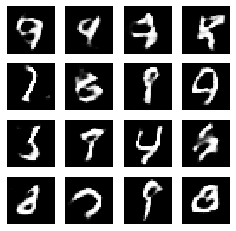

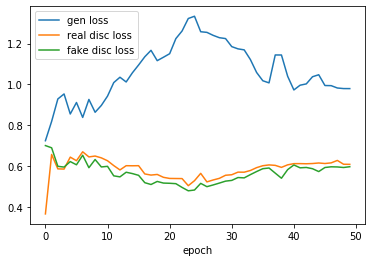

gen loss:  0.9793647996922756
fake disc loss:  0.5963085676761384
real disc loss:  0.6079612284264666


In [16]:
n_epochs = 50
for epoch in range(1, n_epochs+1):
    gen_loss, real_disc_loss, fake_disc_loss = train_epoch(gen_net, disc_net, gen_opt, disc_opt, dataset)
    sample_image = gen_net(sample_noise, training=False)
    gen_loss_history.append(gen_loss)
    real_disc_loss_history.append(real_disc_loss)
    fake_disc_loss_history.append(fake_disc_loss)
    display.clear_output(wait=True)
    print('< Epoch {:d} >'.format(epoch))
    visualize_batch(sample_image.numpy())
    if len(gen_loss_history) >= 2:
        plt.plot(gen_loss_history, label='gen loss')
        plt.plot(real_disc_loss_history, label='real disc loss')
        plt.plot(fake_disc_loss_history, label='fake disc loss')
        plt.legend()
        plt.xlabel('epoch')
        plt.show()
    print('gen loss: ', gen_loss)
    print('fake disc loss: ', fake_disc_loss)
    print('real disc loss: ', real_disc_loss)